# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [31]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 1.999019
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Because there're ten catecories, we expected the average of probabilities to luckily match the true labels is 0.1 when guessing them randomly.*



In [33]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.360936 analytic: -1.802049, relative error: 1.000000e+00
numerical: 59.722213 analytic: 2.122205, relative error: 9.313695e-01
numerical: 1.570314 analytic: 0.299543, relative error: 6.796087e-01
numerical: 2.303911 analytic: -0.075466, relative error: 1.000000e+00
numerical: 3.338822 analytic: -5.615475, relative error: 1.000000e+00
numerical: -3.703633 analytic: -1.778062, relative error: 3.512730e-01
numerical: 0.610191 analytic: -1.048460, relative error: 1.000000e+00
numerical: 0.764125 analytic: 1.406805, relative error: 2.960392e-01
numerical: -1.743281 analytic: -1.499253, relative error: 7.525827e-02
numerical: 1.343128 analytic: -0.378608, relative error: 1.000000e+00
numerical: 0.358862 analytic: -0.901759, relative error: 1.000000e+00
numerical: -241.920108 analytic: 3.919894, relative error: 1.000000e+00
numerical: 0.143922 analytic: -0.535078, relative error: 1.000000e+00
numerical: 0.501821 analytic: 0.812256, relative error: 2.362378e-01
numerical: 2.293794

In [35]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 1.999019e+00 computed in 0.007982s
vectorized loss: 1.892966e+03 computed in 0.002995s
Loss difference: 1890.967269
Gradient difference: 0.000000


In [38]:
d = {}
d[(1, 2)] = (2, 1)
d

{(1, 2): (2, 1)}

In [77]:
mat_A = np.array([1, 2, 3, 3, 4, 4]).reshape((2, 3))
mat_B = np.array([1, 1, 1, 2, 2, 2]).reshape((3, 2))
# mat_A.dot(mat_B)
print(mat_A)
# np.sum(np.argmax(X_val @ W, axis=1) == y_val)
for i in np.arange(*learning_rates, 1e-7):
    print(i)

[[1 2 3]
 [3 4 4]]
1e-07
2e-07
3e-07
4e-07


In [84]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 1e-6]
regularization_strengths = [4e4, 7e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
def validate(W, X, y):
    N = X.shape[0]
    scores = X @ W
    y_pred = np.argmax(scores, axis=1)
    frac = np.sum(y_pred == y) / N
    return frac

def train(X, y, params):
    W = np.random.randn(3073, 10) * 0.0001
    best_loss = -1
    best_model = None
    epochs, lr, reg = params
    for i in range(epochs):
        loss, grad = softmax_loss_vectorized(W, X, y, reg)
        if loss < best_loss or loss < 0:
            best_loss = loss
            best_model = W
        W -= lr * grad
        if (i % 10) == 0:
            print('[PROCEEDING]: {:3d}/{}, loss: {}'.format(i, epochs, round(loss)))
    acc_train = round(validate(W, X, y), 2)
    acc_val = round(validate(W, X_val, y_val), 2)
    print("[RESULTS]: {} {}".format(acc_train, acc_val))
    return best_model, (acc_train, acc_val)

num_epochs = 120

for lr in np.arange(*learning_rates, 1e-7):
    for reg in np.arange(*regularization_strengths, 5e3):
        softmax = Softmax()
        softmax.train(X_train, y_train, lr, reg, num_epochs)
        
        y_pred = softmax.predict(X_train)
        acc_train = np.sum(y_pred == y_train)/y_pred.shape[0]
        y_pred = softmax.predict(X_val)
        acc_val = np.sum(y_pred == y_val)/y_pred.shape[0]
        
        vals = (acc_train, acc_val)
#         model, vals = train(X_train, y_train, (num_epochs, lr, reg))
        if vals[1] > best_val:
            best_val = vals[1]
            best_softmax = softmax
        results[(lr, reg)] = vals



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.154571 val accuracy: 0.140000
lr 1.000000e-07 reg 4.500000e+04 train accuracy: 0.152653 val accuracy: 0.147000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.170163 val accuracy: 0.191000
lr 1.000000e-07 reg 5.500000e+04 train accuracy: 0.155918 val accuracy: 0.183000
lr 1.000000e-07 reg 6.000000e+04 train accuracy: 0.172735 val accuracy: 0.181000
lr 1.000000e-07 reg 6.500000e+04 train accuracy: 0.166245 val accuracy: 0.176000
lr 2.000000e-07 reg 4.000000e+04 train accuracy: 0.196755 val accuracy: 0.212000
lr 2.000000e-07 reg 4.500000e+04 train accuracy: 0.217224 val accuracy: 0.229000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.207388 val accuracy: 0.213000
lr 2.000000e-07 reg 5.500000e+04 train accuracy: 0.210408 val accuracy: 0.212000
lr 2.000000e-07 reg 6.000000e+04 train accuracy: 0.237531 val accuracy: 0.225000
lr 2.000000e-07 reg 6.500000e+04 train accuracy: 0.237735 val accuracy: 0.235000
lr 3.000000e-07 reg 4.000000

In [85]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.337000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



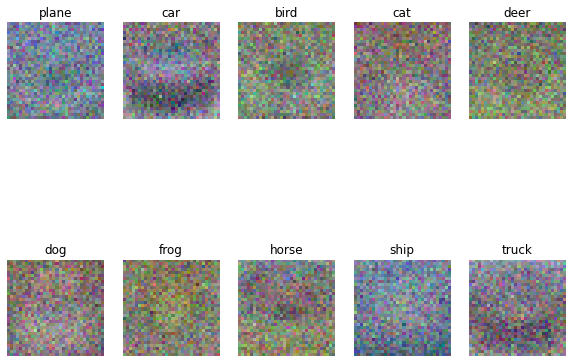

In [86]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])